# Redes Siamesas #

Redes siamesas são arquiteturas que contém duas ou mais subredes __idênticas__. Idêntico, neste caso, significa que elas tem a mesma configuração e os mesmos parâmetros e pesos. Ou seja, ao atualizar um parâmetro em uma rede, o mesmo é atualizado nas outras.

Elas são usadas normalmente em casos onde se procura uma similaridade ou relacionamento entre dois objetos comparáveis. Alguns exemplos:
- Detecção de paráfrase, onde duas sentenças são comparadas e a saída é quão similares elas são.
- Verificação de assinaturas
- Detecção de plágio
- Duplicatas
- Etc

 * [Fonte original](http://sujitpal.blogspot.ch/2017/04/predicting-image-similarity-using.html) deste [notebook](https://github.com/sujitpal/holiday-similarity/blob/master/src/02-holidays-siamese-network.ipynb)

In [20]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

# Organizando dados


In [3]:
from sklearn.model_selection import train_test_split
data_train = pd.read_csv('./data/fashion-mnist_train.csv.zip',compression='zip')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.3)

In [4]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [5]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4222, 4185, 4224, 4207, 4174, 4176, 4192, 4171, 4238, 4211]
test groups: [1778, 1815, 1776, 1793, 1826, 1824, 1808, 1829, 1762, 1789]


### Geração de batches

Temos que criar pares de imagens. Se as imagens são do primeiro grupo é 1, senão é 0.

In [6]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

## Validar entrada


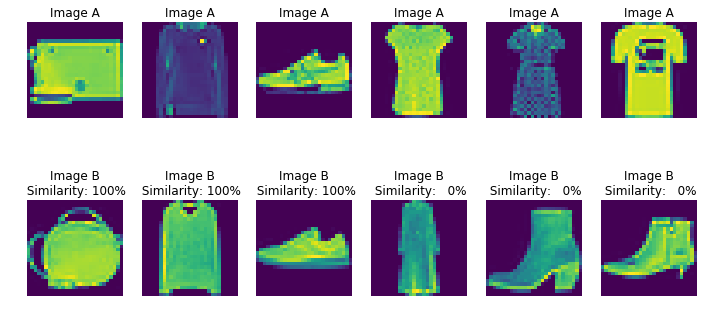

In [21]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

# Rede de geração de features 


In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 16)        0         
__________

# Modelo Siamês

O modelo de features é aplicado a ambas imagens, e a saída delas é combinada para prever se são similares.

A ideia é, ao chegar uma nova imagem, calcular um vetor de features para ela, e procurar em uma base de dados de imagens com vetores pré-treinados os vetores mais similares, por exemplo.

In [22]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Model)  (None, 32)           25040       ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 64)           0           FeatureGenerationModel[3][0]     
          

In [10]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

## Verificação dos resultados

Vamos ver como andam os resultados da rede, antes e depois do treino:

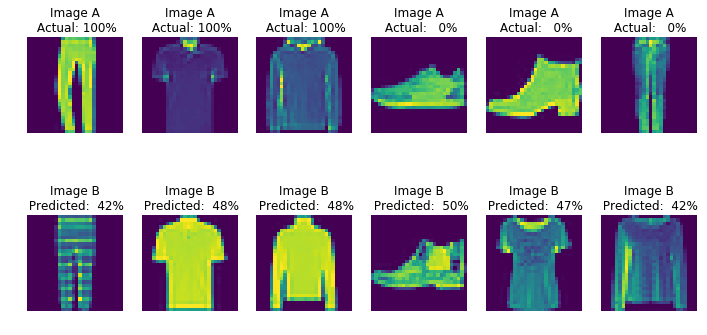

In [23]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [12]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups), 
                               steps_per_epoch = 500,
                               validation_data=([valid_a, valid_b], valid_sim),
                                              epochs = 10,
                                             verbose = True)

Epoch 1/10
500/500 [==============================] - 25s 50ms/step - loss: 0.6657 - mean_absolute_error: 0.4703 - val_loss: 0.5925 - val_mean_absolute_error: 0.4372 - ETA: 14s - loss: 0.71 - ETA: 13s  - ETA: 11s - loss - ETA: 9s - loss: 0.6956 - mean_absolute_er - ETA: 8s - loss: 0.6930 - mean_absolute_error - ETA: 8s - loss: 0.6913 - mean_absolu - ETA: 7s - loss: 0.6886 - mean_absolute_error: 0.48 - ETA: 7s - loss: 0.6882 - mean_absolute_er - ETA: 6s - loss: 0.6850 - - ETA: 4s - loss: 0.6798 - mean_absol - ETA: 3s - loss:  - ETA: 1s - loss: 0.6695 - me
Epoch 2/10
500/500 [==============================] - 26s 53ms/step - loss: 0.5551 - mean_absolute_error: 0.3976 - val_loss: 0.4795 - val_mean_absolute_error: 0.331789 - mean_ab - ETA: 14s - loss: 0.5771 -  - ETA: 6s - loss: 0.5657 - mean_absolute_error: 0.4 - ETA: 6s - loss: 0.5651 - me - ETA: 4s - loss:  - ETA: 2s - loss: 0.5594 - mean_absolute_erro - ETA: 1s - loss: 0.5584 - m
Epoch 3/10
500/500 [==============================] - 27

In [13]:
_ = show_model_output()

# T-Shirt vs Ankle Boot


In [14]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose = True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose = True, batch_size = 128)

18000/18000 [==============================] - 1s 35us/step


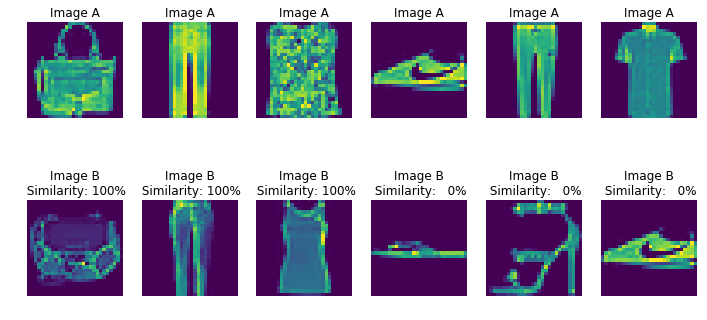

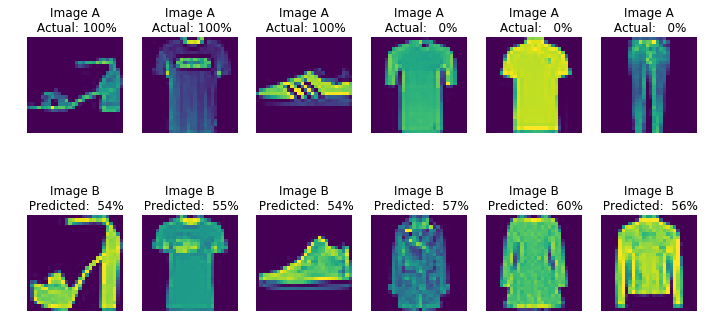

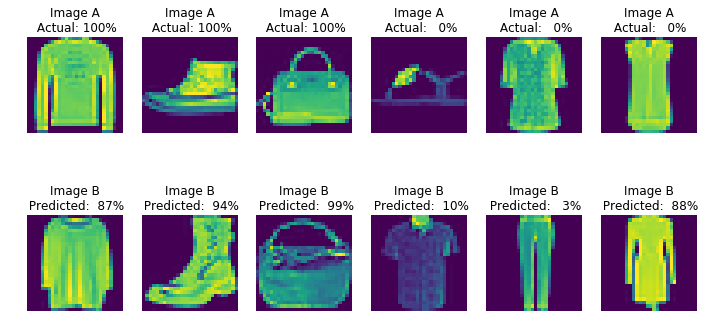

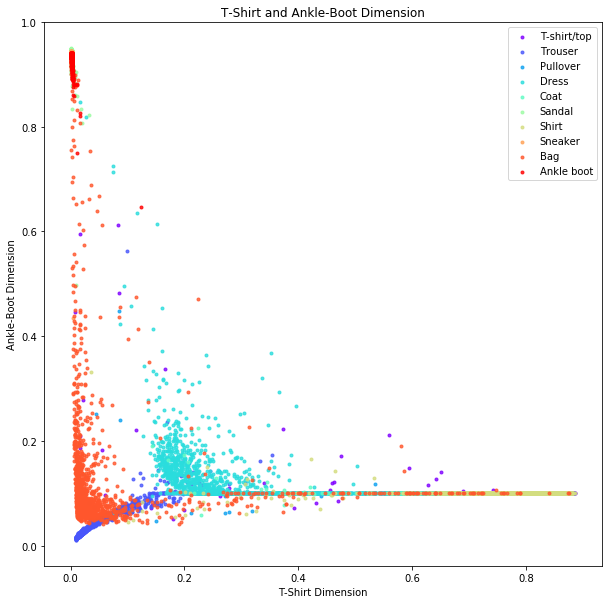

In [15]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(t_shirt_score[np.where(y_test == c_group), 0],
                ankle_boot_score[np.where(y_test == c_group), 0],
                marker='.',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

## Examinando as Features


In [24]:
x_test_features = feature_model.predict(x_test, verbose = True, batch_size=128)

18000/18000 [==============================] - 0s 25us/step


### Vizinhança


In [17]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=500,
                         verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.073s...
[t-SNE] Computed neighbors for 18000 samples in 4.899s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sam

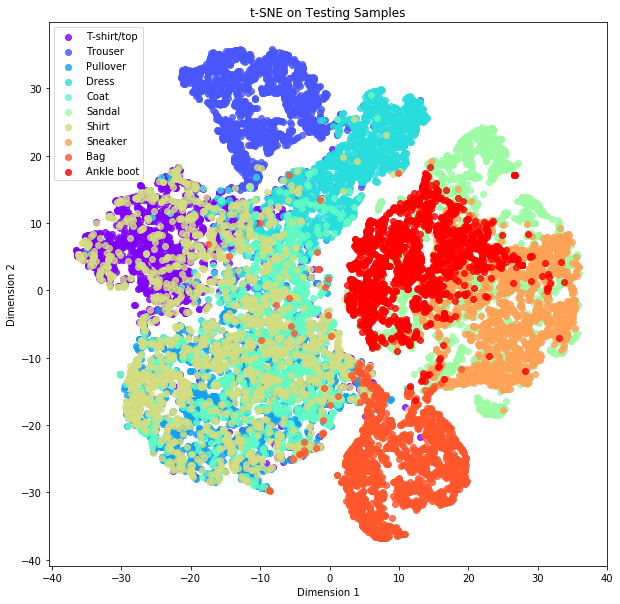

In [18]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
                marker='o',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)

In [ ]:
feature_model.save('fashion_feature_model.h5')

In [ ]:
similarity_model.save('fashion_similarity_model.h5')